# From Unlabeled Data to a Deployed Machine Learning Model: A SageMaker Ground Truth Demonstration for Object Detection

1. [Introduction](#Introduction)
2. [Run a Ground Truth labeling job (time: about 45min)](#Run-a-Ground-Truth-labeling-job)
    1. [Prepare the data](#Prepare-the-data)
    2. [Specify the category](#Specify-the-categories)
    3. [Create the instruction template](#Create-the-instruction-template)
    4. [Create a private team to test your task [OPTIONAL]](#Create-a-private-team-to-test-your-task-[OPTIONAL])
    5. [Define pre-built lambda functions for use in the labeling job](#Define-pre-built-lambda-functions-for-use-in-the-labeling-job)
    6. [Submit the Ground Truth job request](#Submit-the-Ground-Truth-job-request)
        1. [Verify your task using a private team [OPTIONAL]](#Verify-your-task-using-a-private-team-[OPTIONAL])
    7. [Monitor job progress](#Monitor-job-progress)
3. [Analyze Ground Truth labeling job results (time: about 20min)](#Analyze-Ground-Truth-labeling-job-results)
    1. [Postprocess the output manifest](#Postprocess-the-output-manifest)
    2. [Plot class histograms](#Plot-class-histograms)
    3. [Plot annotated images](#Plot-annotated-images)
        1. [Plot a small output sample](#Plot-a-small-output-sample)
        2. [Plot the full results](#Plot-the-full-results)
4. [Compare Ground Truth results to standard labels (time: about 5min)](#Compare-Ground-Truth-results-to-standard-labels)
    1. [Compute accuracy](#Compute-accuracy)
    2. [Plot correct and incorrect annotations](#Plot-correct-and-incorrect-annotations)
5. [Train an object detector using Ground Truth labels (time: about 15min)](#Train-an-image-classifier-using-Ground-Truth-labels)
6. [Deploy the Model (time: about 20min)](#Deploy-the-Model)
    1. [Create Model](#Create-Model)
    2. [Batch Transform](#Batch-Transform)
7. [Review](#Review)

# Introduction

This sample notebook takes you through an end-to-end workflow to demonstrate the functionality of SageMaker Ground Truth. We'll start with an unlabeled image data set, acquire bounding boxes for objects in the images using SageMaker Ground Truth, analyze the results, train an object detector, host the resulting model, and, finally, use it to make predictions. Before you begin, we highly recommend you start a Ground Truth labeling job through the AWS Console first to familiarize yourself with the workflow. The AWS Console offers less flexibility than the API, but is simple to use.

#### Cost and runtime
You can run this demo in two modes:
1. Set `RUN_FULL_AL_DEMO = True` in the next cell to label 1000 images. This should cost about $200 given the current [Ground Truth pricing scheme](https://aws.amazon.com/sagemaker/groundtruth/pricing/). In order to reduce the cost, we will use Ground Truth's auto-labeling feature. Auto-labeling uses computer vision to learn from human responses and automatically create bounding boxes for the easiest images at a cheap price. The total end-to-end runtime should be about 6h.
1. Set `RUN_FULL_AL_DEMO = False` in the next cell to label only 10 images. This should cost \$2.60. **Since Ground Truth's auto-labeling feature only kicks in for datasets of 1000 images or more, this cheaper version of the demo will not use it. Some of the analysis plots might look awkward, but you should still be able to see good results on the human-annotated 10 images.**

#### Prerequisites
To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:
* An S3 bucket you can write to -- please provide its name in the following cell. The bucket must be in the same region as this SageMaker Notebook instance. You can also change the `EXP_NAME` to any valid S3 prefix. All the files related to this experiment will be stored in that prefix of your bucket. 
* Familiarity with Python and [numpy](http://www.numpy.org/).
* Basic familiarity with [AWS S3](https://docs.aws.amazon.com/s3/index.html).
* Basic understanding of [AWS Sagemaker](https://aws.amazon.com/sagemaker/).
* Basic familiarity with [AWS Command Line Interface (CLI)](https://aws.amazon.com/cli/) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.

This notebook has only been tested on a SageMaker notebook instance. The runtimes given are approximate. We used an `ml.m4.xlarge` instance in our tests. However, you can likely run it on a local instance by first executing the cell below on SageMaker and then copying the `role` string to your local copy of the notebook.

In [ ]:
%matplotlib inline
import os
from collections import namedtuple
from collections import defaultdict
from collections import Counter
from datetime import datetime
import itertools
import base64
import glob
import json
import random
import time
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shutil
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import boto3
import botocore
import sagemaker
from urllib.parse import urlparse

BUCKET = '<< YOUR S3 BUCKET NAME >>'
EXP_NAME = 'ground-truth-od-full-demo' # Any valid S3 prefix.
RUN_FULL_AL_DEMO = False # See 'Cost and Runtime' in the Markdown cell above!

In [ ]:
# Make sure the bucket is in the same region as this notebook.
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

# Run a Ground Truth labeling job

**This section should take about 4 hours to complete.**

We will first run a labeling job. This involves several steps: collecting the images we want annotated, creating instructions, and writing a labeling job specification. In addition, we highly recommend that you run a (free) mock job using a private workforce before you submit any job to the public workforce. This notebook will explain how to do that as an optional step. Using a public workforce, this section should take about 4 hours. However, this will vary depending on the availability of workers.

### Prepare the data
We will first download images and labels of a subset of the [Google Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html). These labels were [carefully verified](https://storage.googleapis.com/openimages/web/factsfigures.html). Later, we will compare Ground Truth annotations to these labels. Our dataset will consist of images of various species of bird.

If you chose `RUN_FULL_AL_DEMO = False`, then we will choose a subset of 10 images from this dataset. This is a diverse dataset of interesting images, and it should be fun for the human annotators to work with. You are free to ask the annotators to annotate any images you wish as long as the images do not contain adult content. In this case, you must adjust the labeling job request this job produces; please check the Ground Truth documentation.

We will copy these images to our local `BUCKET` and create a corresponding *input manifest*. The input manifest is a formatted list of the S3 locations of the images we want Ground Truth to annotate. We will upload this manifest to our S3 `BUCKET`.

#### Disclosure regarding the Open Images Dataset V4:
Open Images Dataset V4 is created by Google Inc. We have not modified the images or the accompanying annotations. You can obtain the images and the annotations [here](https://storage.googleapis.com/openimages/web/download.html). The annotations are licensed by Google Inc. under [CC BY 4.0](https://creativecommons.org/licenses/by/2.0/) license. The images are listed as having a [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/) license. The following paper describes Open Images V4 in depth: from the data collection and annotation to detailed statistics about the data and evaluation of models trained on it.

A. Kuznetsova, H. Rom, N. Alldrin, J. Uijlings, I. Krasin, J. Pont-Tuset, S. Kamali, S. Popov, M. Malloci, T. Duerig, and V. Ferrari.
*The Open Images Dataset V4: Unified image classification, object detection, and visual relationship detection at scale.* arXiv:1811.00982, 2018. ([link to PDF](https://arxiv.org/abs/1811.00982))

In [ ]:
# Download and process the Open Images annotations.
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv
!wget https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json
    
with open('bbox_labels_600_hierarchy.json', 'r') as f:
    hierarchy = json.load(f)
    
CLASS_NAME = 'Bird'
CLASS_ID = '/m/015p6'

# Find all the subclasses of the desired image class (e.g. 'swans' and 'pigeons' etc if CLASS_NAME=='Bird').
good_subclasses = set()
def get_all_subclasses(hierarchy, good_subtree=False):
    if hierarchy['LabelName'] == CLASS_ID:
        good_subtree = True
    if good_subtree:
        good_subclasses.add(hierarchy['LabelName'])
    if 'Subcategory' in hierarchy:            
        for subcat in hierarchy['Subcategory']:
            get_all_subclasses(subcat, good_subtree=good_subtree)
    return good_subclasses
good_subclasses = get_all_subclasses(hierarchy)

# Find an appropriate number of images with at least one bounding box in the desired category
if RUN_FULL_AL_DEMO:
    n_ims = 1000
else:
    n_ims = 10
    
fids2bbs = defaultdict(list)
# Skip images with risky content.
skip_these_images = ['251d4c429f6f9c39', 
                    '065ad49f98157c8d']

with open('test-annotations-bbox.csv', 'r') as f:
    for line in f.readlines()[1:]:
        line = line.strip().split(',')
        img_id, _, cls_id, conf, xmin, xmax, ymin, ymax, *_ = line
        if img_id in skip_these_images:
            continue
        if cls_id in good_subclasses:
            fids2bbs[img_id].append([CLASS_NAME, xmin, xmax, ymin, ymax])
            if len(fids2bbs) == n_ims:
                break

# Copy the images to our local bucket.
s3 = boto3.client('s3')
for img_id_id, img_id in enumerate(fids2bbs.keys()):
    if img_id_id % 100 == 0:
        print('Copying image {} / {}'.format(img_id_id, n_ims))
    copy_source = {
        'Bucket': 'open-images-dataset',
        'Key': 'test/{}.jpg'.format(img_id)
    }
    s3.copy(copy_source, BUCKET, '{}/images/{}.jpg'.format(EXP_NAME, img_id))
print('Done!')

# Create and upload the input manifest.
manifest_name = 'input.manifest'
with open(manifest_name, 'w') as f:
    for img_id_id, img_id in enumerate(fids2bbs.keys()):
        img_path = 's3://{}/{}/images/{}.jpg'.format(BUCKET, EXP_NAME, img_id)
        f.write('{"source-ref": "' + img_path +'"}\n')
s3.upload_file(manifest_name, BUCKET, EXP_NAME + '/' + manifest_name)

After running the cell above, you should be able to go to `s3://BUCKET/EXP_NAME/images` in the [S3 console](https://console.aws.amazon.com/s3/) and see 1000 images (or 100 if you have set `RUN_FULL_AL_DEMO = False`). We recommend you inspect these images! You can download them to a local machine using the AWS CLI.

## Specify the categories

To run an object detection labeling job, you must decide on a set of classes the annotators can choose from. At the moment, Ground Truth only supports annotating one OD class at a time. In our case, the singleton class list is simply `["Bird"]`.  To work with Ground Truth, this list needs to be converted to a .json file and uploaded to the S3 `BUCKET`.

In [ ]:
CLASS_LIST = [CLASS_NAME]
print("Label space is {}".format(CLASS_LIST))

json_body = {
    'labels': [{'label': label} for label in CLASS_LIST]
}
with open('class_labels.json', 'w') as f:
    json.dump(json_body, f)
    
s3.upload_file('class_labels.json', BUCKET, EXP_NAME + '/class_labels.json')

You should now see `class_labels.json` in `s3://BUCKET/EXP_NAME/`.

## Create the instruction template

Part or all of your images will be annotated by human annotators. It is **essential** to provide good instructions. Good instructions are:
1. Concise. We recommend limiting verbal/textual instruction to two sentences and focusing on clear visuals.
2. Visual. In the case of object detection, we recommend providing several labeled examples with different numbers of boxes.

When used through the AWS Console, Ground Truth helps you create the instructions using a visual wizard. When using the API, you need to create an HTML template for your instructions. Below, we prepare a very simple but effective template and upload it to your S3 bucket.

NOTE: If you use any images in your template (as we do), they need to be publicly accessible. You can enable public access to files in your S3 bucket through the S3 Console, as described in [S3 Documentation](https://docs.aws.amazon.com/AmazonS3/latest/user-guide/set-object-permissions.html). 

#### Testing your instructions
**It is very easy to create broken instructions.** This might cause your labeling job to fail. However, it might also cause your job to complete with meaningless results if, for example, the annotators have no idea what to do or the instructions are misleading. At the moment the only way to test the instructions is to run your job in a private workforce. This is a way to run a mock labeling job for free. We describe how in [Verify your task using a private team [OPTIONAL]](#Verify-your-task-using-a-private-team-[OPTIONAL]).

It is helpful to show examples of correctly labeled images in the instructions. The following code block produces several such examples for our dataset and saves them in `s3://BUCKET/EXP_NAME/`.

In [ ]:
# Plot sample images.
def plot_bbs(ax, bbs, img):
    '''Add bounding boxes to images.'''
    ax.imshow(img)
    imh, imw, _ = img.shape
    for bb in bbs:
        xmin, xmax, ymin, ymax = bb
        xmin *= imw
        xmax *= imw
        ymin *= imh
        ymax *= imh
        rec = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, lw=4, edgecolor='blue')
        ax.add_patch(rec)
        
plt.figure(facecolor='white', dpi=100, figsize=(3, 7))
plt.suptitle('Please draw a box\n around each {}\n like the examples below.\n Thank you!'.format(CLASS_NAME), fontsize=15)
for fid_id, (fid, bbs) in enumerate([list(fids2bbs.items())[idx] for idx in [1, 3]]):
    !aws s3 cp s3://open-images-dataset/test/{fid}.jpg .
    img = imageio.imread(fid + '.jpg')
    bbs = [[float(a) for a in annot[1:]] for annot in bbs]
    ax = plt.subplot(2, 1, fid_id+1)
    plot_bbs(ax, bbs, img)
    plt.axis('off')
    
plt.savefig('instructions.png', dpi=60)
with open('instructions.png', 'rb') as instructions:
    instructions_uri = base64.b64encode(instructions.read()).decode('utf-8').replace('\n', '')

In [ ]:
from IPython.core.display import HTML, display

def make_template(test_template=False, save_fname='instructions.template'):
    template = r"""<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>
    <crowd-form>
      <crowd-bounding-box
        name="boundingBox"
        src="{{{{ task.input.taskObject | grant_read_access }}}}"
        header="Dear Annotator, please draw a tight box around each {class_name} you see (if there are more than 8 birds, draw boxes around at least 8). Thank you!"
        labels="{labels_str}"
      >
        <full-instructions header="Please annotate each {class_name}.">

    <ol>
        <li><strong>Inspect</strong> the image</li>
        <li><strong>Determine</strong> if the specified label is/are visible in the picture.</li>
        <li><strong>Outline</strong> each instance of the specified label in the image using the provided “Box” tool.</li>
    </ol>
    <ul>
        <li>Boxes should fit tight around each object</li>
        <li>Do not include parts of the object are overlapping or that cannot be seen, even though you think you can interpolate the whole shape.</li>
        <li>Avoid including shadows.</li>
        <li>If the target is off screen, draw the box up to the edge of the image.</li>
    </ul>

        </full-instructions>
        <short-instructions>
        <img src="data:image/png;base64,{instructions_uri}" style="max-width:100%">
        </short-instructions>
      </crowd-bounding-box>
    </crowd-form>
    """.format(class_name=CLASS_NAME,
               instructions_uri=instructions_uri,
               labels_str=str(CLASS_LIST) if test_template else '{{ task.input.labels | to_json | escape }}')
    with open(save_fname, 'w') as f:
        f.write(template)

        
make_template(test_template=True, save_fname='instructions.html')
make_template(test_template=False, save_fname='instructions.template')
s3.upload_file('instructions.template', BUCKET, EXP_NAME + '/instructions.template')

You should now be able to find your template in `s3://BUCKET/EXP_NAME/instructions.template`.

## Create a private team to test your task [OPTIONAL]
This step requires you to use the AWS Console. However, we **highly recommend** that you follow it, especially when creating your own task with a custom dataset, label set, and template.

We will create a `private workteam` and add only one user (you) to it. Then, we will modify the Ground Truth API job request to send the task to that workforce. You will then be able to see your annotation job exactly as the public annotators would see it. You could even annotate the whole dataset yourself! 

To create a private team:
1. Go to `AWS Console > Amazon SageMaker > Labeling workforces`
2. Click "Private" and then "Create private team". 
3. Enter the desired name for your private workteam.
4. Select "Create a new Amazon Cognito user group" and click "Create private team."
5. The AWS Console should now return to `AWS Console > Amazon SageMaker > Labeling workforces`.
6. Click on "Invite new workers" in the "Workers" tab.
7. Enter your own email address in the "Email addresses" section and click "Invite new workers."
8. Click on your newly created team under the "Private teams" tab.
9. Select the "Workers" tab and click "Add workers to team."
10. Select your email and click "Add workers to team."
11. The AWS Console should again return to `AWS Console > Amazon SageMaker > Labeling workforces`. Your newly created team should be visible under "Private teams". Next to it you will see an `ARN` which is a long string that looks like `arn:aws:sagemaker:region-name-123456:workteam/private-crowd/team-name`. Copy this ARN into the cell below.
12. You should get an email from `no-reply@verificationemail.com` that contains your workforce username and password. 
13. In `AWS Console > Amazon SageMaker > Labeling workforces > Private`, click on the URL under `Labeling portal sign-in URL`. Use the email/password combination from the previous step to log in (you will be asked to create a new, non-default password).

That's it! This is your private worker's interface. When we create a verification task in [Verify your task using a private team](#Verify-your-task-using-a-private-team-[OPTIONAL]) below, your task should appear in this window. You can invite your colleagues to participate in the labeling job by clicking the "Invite new workers" button.

The [SageMaker Ground Truth documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management-private.html) has more details on the management of private workteams. 

In [ ]:
private_workteam_arn = '<< your private workteam ARN here >>'

## Define pre-built lambda functions for use in the labeling job 

Before we submit the request, we need to define the ARNs for four key components of the labeling job: 1) the workteam, 2) the annotation consolidation Lambda function, 3) the pre-labeling task Lambda function, and 4) the machine learning algorithm to perform auto-annotation. These functions are defined by strings with region names and AWS service account numbers, so we will define a mapping below that will enable you to run this notebook in any of our supported regions. 

See the official documentation for the available ARNs:
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_HumanTaskConfig.html#SageMaker-Type-HumanTaskConfig-PreHumanTaskLambdaArn) for available pre-human ARNs for other workflows.
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_AnnotationConsolidationConfig.html#SageMaker-Type-AnnotationConsolidationConfig-AnnotationConsolidationLambdaArn) for available annotation consolidation ANRs for other workflows.
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_LabelingJobAlgorithmsConfig.html#SageMaker-Type-LabelingJobAlgorithmsConfig-LabelingJobAlgorithmSpecificationArn) for available auto-labeling ARNs for other workflows.

In [ ]:
# Specify ARNs for resources needed to run an object detection job.
ac_arn_map = {'us-west-2': '081040173940',
              'us-east-1': '432418664414',
              'us-east-2': '266458841044',
              'eu-west-1': '568282634449',
              'ap-northeast-1': '477331159723'}

prehuman_arn = 'arn:aws:lambda:{}:{}:function:PRE-BoundingBox'.format(region, ac_arn_map[region])
acs_arn = 'arn:aws:lambda:{}:{}:function:ACS-BoundingBox'.format(region, ac_arn_map[region]) 
labeling_algorithm_specification_arn = 'arn:aws:sagemaker:{}:027400017018:labeling-job-algorithm-specification/object-detection'.format(region)
workteam_arn = 'arn:aws:sagemaker:{}:394669845002:workteam/public-crowd/default'.format(region)

## Submit the Ground Truth job request
The API starts a Ground Truth job by submitting a request. The request contains the 
full configuration of the annotation task, and allows you to modify the fine details of
the job that are fixed to default values when you use the AWS Console. The parameters that make up the request are described in more detail in the [SageMaker Ground Truth documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateLabelingJob.html).

After you submit the request, you should be able to see the job in your AWS Console, at `Amazon SageMaker > Labeling Jobs`.
You can track the progress of the job there. This job will take several hours to complete. If your job
is larger (say 100,000 images), the speed and cost benefit of auto-labeling should be larger.

### Verify your task using a private team [OPTIONAL]
If you chose to follow the steps in [Create a private team](#Create-a-private-team-to-test-your-task-[OPTIONAL]), you can first verify that your task runs as expected. To do this:
1. Set VERIFY_USING_PRIVATE_WORKFORCE to True in the cell below.
2. Run the next two cells. This will define the task and submit it to the private workforce (you).
3. After a few minutes, you should be able to see your task in your private workforce interface [Create a private team](#Create-a-private-team-to-test-your-task-[OPTIONAL]).
Please verify that the task appears as you want it to appear.
4. If everything is in order, change `VERIFY_USING_PRIVATE_WORKFORCE` to `False` and rerun the cell below to start the real annotation task!

In [ ]:
VERIFY_USING_PRIVATE_WORKFORCE = False
USE_AUTO_LABELING = True

task_description = 'Dear Annotator, please draw a box around each {}. Thank you!'.format(CLASS_NAME)
task_keywords = ['image', 'object', 'detection']
task_title = 'Please draw a box around each {}.'.format(CLASS_NAME)
job_name = 'ground-truth-od-demo-' + str(int(time.time()))

human_task_config = {
      "AnnotationConsolidationConfig": {
        "AnnotationConsolidationLambdaArn": acs_arn,
      },
      "PreHumanTaskLambdaArn": prehuman_arn,
      "MaxConcurrentTaskCount": 200, # 200 images will be sent at a time to the workteam.
      "NumberOfHumanWorkersPerDataObject": 5, # We will obtain and consolidate 5 human annotations for each image.
      "TaskAvailabilityLifetimeInSeconds": 21600, # Your workteam has 6 hours to complete all pending tasks.
      "TaskDescription": task_description,
      "TaskKeywords": task_keywords,
      "TaskTimeLimitInSeconds": 300, # Each image must be labeled within 5 minutes.
      "TaskTitle": task_title,
      "UiConfig": {
        "UiTemplateS3Uri": 's3://{}/{}/instructions.template'.format(BUCKET, EXP_NAME),
      }
    }

if not VERIFY_USING_PRIVATE_WORKFORCE:
    human_task_config["PublicWorkforceTaskPrice"] = {
        "AmountInUsd": {
           "Dollars": 0,
           "Cents": 3,
           "TenthFractionsOfACent": 6,
        }
    } 
    human_task_config["WorkteamArn"] = workteam_arn
else:
    human_task_config["WorkteamArn"] = private_workteam_arn

ground_truth_request = {
        "InputConfig" : {
          "DataSource": {
            "S3DataSource": {
              "ManifestS3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME, manifest_name),
            }
          },
          "DataAttributes": {
            "ContentClassifiers": [
              "FreeOfPersonallyIdentifiableInformation",
              "FreeOfAdultContent"
            ]
          },  
        },
        "OutputConfig" : {
          "S3OutputPath": 's3://{}/{}/output/'.format(BUCKET, EXP_NAME),
        },
        "HumanTaskConfig" : human_task_config,
        "LabelingJobName": job_name,
        "RoleArn": role, 
        "LabelAttributeName": "category",
        "LabelCategoryConfigS3Uri": 's3://{}/{}/class_labels.json'.format(BUCKET, EXP_NAME),
    }

if USE_AUTO_LABELING and RUN_FULL_AL_DEMO:
    ground_truth_request[ "LabelingJobAlgorithmsConfig"] = {
            "LabelingJobAlgorithmSpecificationArn": labeling_algorithm_specification_arn
                                       }
    
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_labeling_job(**ground_truth_request)

## Interlude - Setting up a labeling job using the console
The labelling job that was just kicked off will take about 15 minutes to complete, even though it is only 10 images. This is because actual humans are executing it! While this is running take the time to set up another labelling job using the AWS console. This is user friendly and gives you a good understanding of the configuration and process.

1. Go to the aws console https://console.aws.amazon.com
2. Under Services go to Amazon SageMaker
3. Go to GroundTruth > Labeling Jobs > Create Labeling Job
4. Enter the details as shown below, replacing the bucket name with the bucket you are using for this workshop. Under the output data make sure to select a new folder, different to the public workforce labelling job we launched previously.

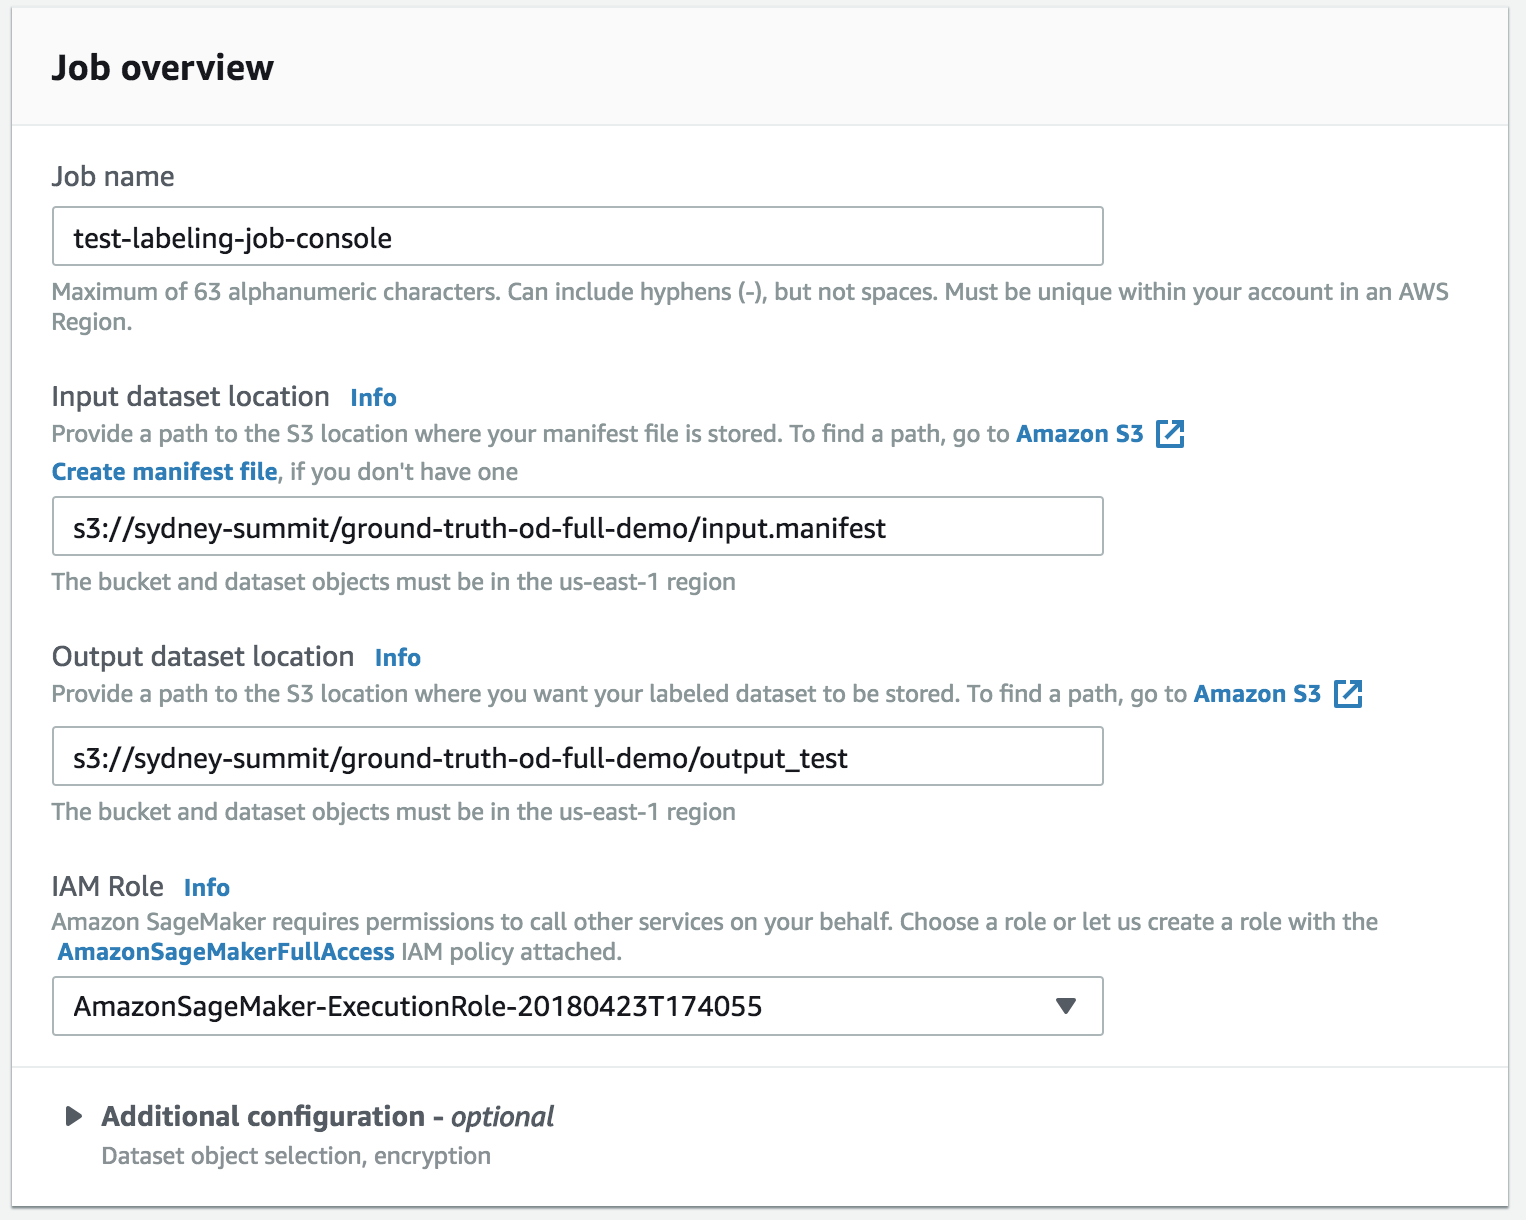

5. Under Task type select bounding box:

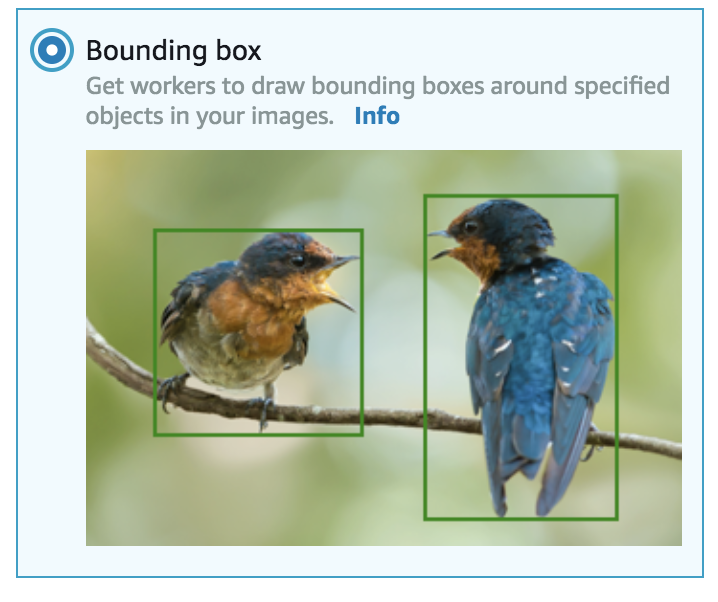

6. Select a public workforce and check the disclaimers:

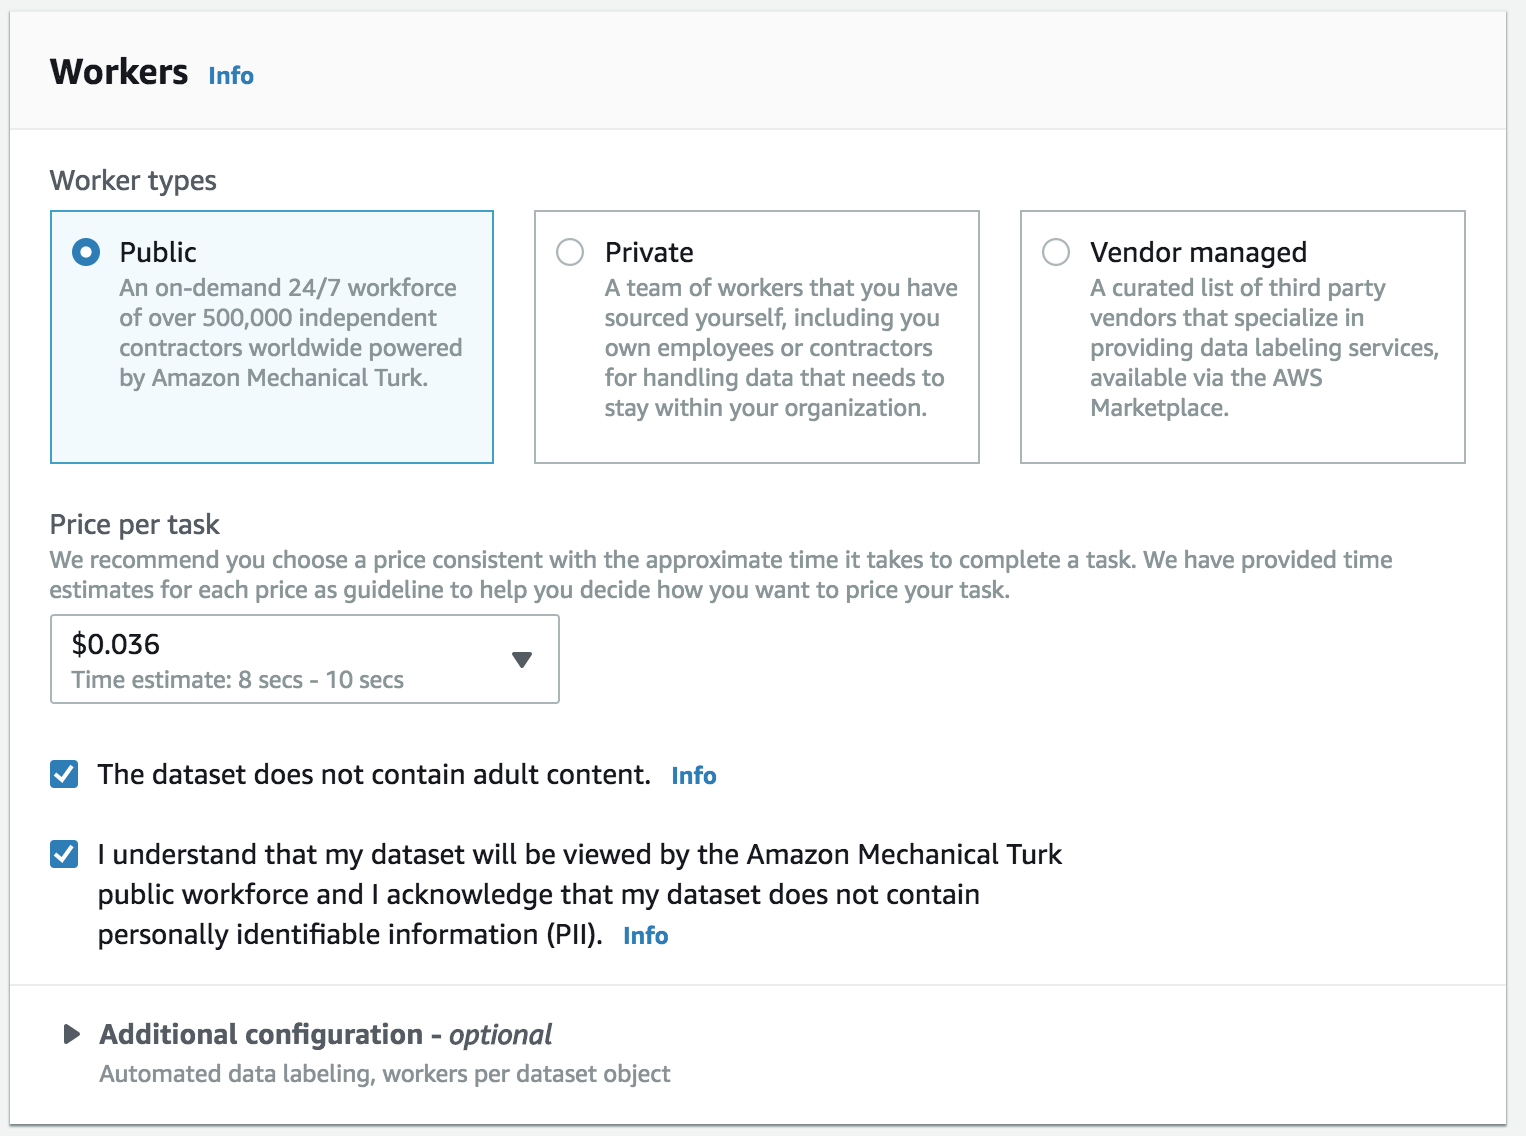

7. Add the label 'bird' by typing in the text and clicking on 'Add label'
8. Enter a description of your task, upload some examples, and preview the user interface
8. Click submit to launch the labeling job

The job_name you entered in step 4 can be used below instead of the job created in the notebook if you wish, it will take about 15 minutes to complete.

## Monitor job progress
A Ground Truth job can take a few hours to complete (if your dataset is larger than 10000 images, it can take much longer than that!). One way to monitor the job's progress is through AWS Console. In this notebook, we will use Ground Truth output files and Cloud Watch logs in order to monitor the progress.

You can re-evaluate the next cell repeatedly. It sends a `describe_labeling_job` request which should tell you whether the job is completed or not. If it is, then 'LabelingJobStatus' will be 'Completed'.

In [ ]:
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

The next cell extracts detailed information on how your job is doing. You can re-evaluate it at any time. It should give you:
* The number of human and machine-annotated images across the iterations of your labeling job.
* The training curves of any neural network training jobs launched by Ground Truth **(only if you are running with `RUN_FULL_AL_DEMO=True`)**.
* The cost of the human- and machine-annotated labels.

To understand the pricing, study [this document](https://aws.amazon.com/sagemaker/groundtruth/pricing/) carefully. In our case, each human label costs `$0.08 + 5 * $0.036 = $0.26` and each auto-label costs `$0.08`. If you set `RUN_FULL_AL_DEMO=True`, there is also the added cost of using SageMaker instances for neural net training and inference during auto-labeling. However, this should be insignificant compared to the other costs.

If `RUN_FULL_AL_DEMO==True`, then the job will proceed in multiple iterations. 
* Iteration 1: Ground Truth will send out 10 images as 'probes' for human annotation. If these are successfully annotated, proceed to Iteration 2.
* Iteration 2: Send out a batch of `MaxConcurrentTaskCount - 10` (in our case, 190) images for human annotation to obtain an active learning training batch.
* Iteration 3: Send out another batch of 200 images for human annotation to obtain an active learning validation set.
* Iteration 4a: Train a neural net to do auto-labeling. Auto-label as many data points as possible. 
* Iteration 4b: If there is any data leftover, send out at most 200 images for human annotation.
* Repeat Iteration 4a and 4b until all data is annotated.

If `RUN_FULL_AL_DEMO==False`, only Iterations 1 and 2 will happen.

In [ ]:
HUMAN_PRICE = 0.26
AUTO_PRICE = 0.08

try:
    os.makedirs('od_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('od_output_data/')
    
S3_OUTPUT = boto3.client('sagemaker').describe_labeling_job(LabelingJobName=job_name)[
    'OutputConfig']['S3OutputPath'] + job_name

# Count number of human annotations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/annotations/consolidated-annotation/consolidation-response'} od_output_data/consolidation-response --recursive --quiet
consolidated_nboxes = defaultdict(int)
consolidated_nims = defaultdict(int)
consolidation_times = {}
consolidated_cost_times = []
obj_ids = set()

for consolidated_fname in glob.glob('od_output_data/consolidation-response/**', recursive=True):
    if consolidated_fname.endswith('json'):
        iter_id = int(consolidated_fname.split('/')[-2][-1])
        # Store the time of the most recent consolidation event as iteration time.
        iter_time = datetime.strptime(consolidated_fname.split('/')[-1], '%Y-%m-%d_%H:%M:%S.json')
        if iter_id in consolidation_times:
            consolidation_times[iter_id] = max(consolidation_times[iter_id], iter_time)
        else:
            consolidation_times[iter_id] = iter_time
        consolidated_cost_times.append(iter_time)
                                      
        with open(consolidated_fname, 'r') as f:
            consolidated_data = json.load(f)
        for consolidation in consolidated_data:
            obj_id = consolidation['datasetObjectId']
            n_boxes = len(consolidation['consolidatedAnnotation']['content'][
                'category']['annotations'])
            if obj_id not in obj_ids:
                obj_ids.add(obj_id)
                consolidated_nims[iter_id] += 1            
                consolidated_nboxes[iter_id] += n_boxes
            
total_human_labels = sum(consolidated_nims.values())
            
# Count the number of machine iterations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/activelearning'} od_output_data/activelearning --recursive --quiet
auto_nboxes = defaultdict(int)
auto_nims = defaultdict(int)
auto_times = {}
auto_cost_times = []

for auto_fname in glob.glob('od_output_data/activelearning/**', recursive=True):
    if auto_fname.endswith('auto_annotator_output.txt'):
        iter_id = int(auto_fname.split('/')[-3])
        with open(auto_fname, 'r') as f:
            annots = [' '.join(l.split()[1:]) for l in f.readlines()]
        auto_nims[iter_id] += len(annots)
        for annot in annots:
            annot = json.loads(annot)
            time_str = annot['category-metadata']['creation-date']
            auto_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%f')
            n_boxes = len(annot['category']['annotations'])
            auto_nboxes[iter_id] += n_boxes
            if iter_id in auto_times:
                auto_times[iter_id] = max(auto_times[iter_id], auto_time)
            else:
                auto_times[iter_id] = auto_time
            auto_cost_times.append(auto_time)
                
total_auto_labels = sum(auto_nims.values())
n_iters = max(len(auto_times), len(consolidation_times))

# Get plots for auto-annotation neural-net training.
def get_training_job_data(training_job_name):
    logclient = boto3.client('logs')
    log_group_name = '/aws/sagemaker/TrainingJobs'
    log_stream_name = logclient.describe_log_streams(logGroupName=log_group_name,
        logStreamNamePrefix=training_job_name)['logStreams'][0]['logStreamName']
    train_log = logclient.get_log_events(
        logGroupName=log_group_name,
        logStreamName=log_stream_name,
        startFromHead=True
    )
    events = train_log['events']
    next_token = train_log['nextForwardToken']
    while True:
        train_log = logclient.get_log_events(
            logGroupName=log_group_name,
            logStreamName=log_stream_name,
            startFromHead=True,
            nextToken=next_token
        )
        if train_log['nextForwardToken'] == next_token:
            break
        events = events + train_log['events']

    mAPs = []
    for event in events:
        msg = event['message']
        if 'Final configuration' in msg:
            num_samples = int(msg.split('num_training_samples\': u\'')[1].split('\'')[0])
        elif 'validation mAP <score>=(' in msg:
            mAPs.append(float(msg.split('validation mAP <score>=(')[1][:-1]))

    return num_samples, mAPs

training_data = !aws s3 ls {S3_OUTPUT + '/training/'} --recursive
training_sizes = []
training_mAPs = []
training_iters = []
for line in training_data:
    if line.split('/')[-1] == 'model.tar.gz':
        training_job_name = line.split('/')[-3]
        n_samples, mAPs = get_training_job_data(training_job_name)
        training_sizes.append(n_samples)
        training_mAPs.append(mAPs)
        training_iters.append(int(line.split('/')[-5]))
        
plt.figure(facecolor='white', figsize=(14, 5), dpi=100)
ax = plt.subplot(131)
total_human = 0
total_auto = 0
for iter_id in range(1, n_iters + 1):
    cost_human = consolidated_nims[iter_id] * HUMAN_PRICE
    cost_auto = auto_nims[iter_id] * AUTO_PRICE
    total_human += cost_human
    total_auto += cost_auto
    
    plt.bar(iter_id, cost_human, width=.8, color='C0',
            label='human' if iter_id==1 else None)
    plt.bar(iter_id, cost_auto, bottom=cost_human,
            width=.8, color='C1', label='auto' if iter_id==1 else None)
plt.title('Total annotation costs:\n\${:.2f} human, \${:.2f} auto'.format(
    total_human, total_auto))
plt.xlabel('Iter')
plt.ylabel('Cost in dollars')
plt.legend()

plt.subplot(132)
plt.title('Total annotation counts:\nHuman: {} ims, {} boxes\nMachine: {} ims, {} boxes'.format(
    sum(consolidated_nims.values()), sum(consolidated_nboxes.values()), sum(auto_nims.values()), sum(auto_nboxes.values())))
for iter_id in consolidated_nims.keys():
    plt.bar(iter_id, auto_nims[iter_id], color='C1', width=.4, label='ims, auto' if iter_id==1 else None)
    plt.bar(iter_id, consolidated_nims[iter_id],
            bottom=auto_nims[iter_id], color='C0', width=.4, label='ims, human' if iter_id==1 else None)
    plt.bar(iter_id + .4, auto_nboxes[iter_id], color='C1', alpha=.4, width=.4, label='boxes, auto' if iter_id==1 else None)
    plt.bar(iter_id + .4, consolidated_nboxes[iter_id],
            bottom=auto_nboxes[iter_id], color='C0', width=.4, alpha=.4, label='boxes, human' if iter_id==1 else None)

tick_labels_boxes = ['Iter {}, boxes'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_labels_images = ['Iter {}, images'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_locations_images = np.arange(n_iters) + 1
tick_locations_boxes = tick_locations_images + .4
tick_labels = np.concatenate([[tick_labels_boxes[idx], tick_labels_images[idx]] for idx in range(n_iters)])
tick_locations = np.concatenate([[tick_locations_boxes[idx], tick_locations_images[idx]] for idx in range(n_iters)])
plt.xticks(tick_locations, tick_labels, rotation=90)
plt.legend()
plt.ylabel('Count')

if len(training_sizes) > 0:
    plt.subplot(133)
    plt.title('Active learning training curves')
    plt.grid(True)

    cmap = plt.get_cmap('coolwarm')
    n_all = len(training_sizes)
    for iter_id_id, (iter_id, size, mAPs) in enumerate(zip(training_iters, training_sizes, training_mAPs)):
        plt.plot(mAPs, label='Iter {}, auto'.format(iter_id + 1), color=cmap(iter_id_id / max(1, (n_all-1))))
        plt.legend()

    plt.xlabel('Training epoch')
    plt.ylabel('Validation mAP')

plt.tight_layout()

# Analyze Ground Truth labeling job results
**This section should take about 20 minutes to complete.**

Once the job has finished, we can analyze the results. Evaluate the following cell and verify the output is `'Completed'` before continuing.

In [ ]:
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

The plots in the [Monitor job progress](#Monitor-job-progress) section form part of the analysis. In this section, we will gain additional insights into the results, which are contained in the output manifest. You can find the location of the output manifest under `AWS Console > SageMaker > Labeling Jobs > [name of your job]`. We will obtain it programmatically in the cell below.

## Postprocess the output manifest
Now that the job is complete, we will download the output manifest manfiest and postprocess it to create a list of `output_images` with the results. Each entry in the list will be a `BoxedImage` object that contains information about the image and the bounding boxes created by the labeling jobs.

In [ ]:
# Load the output manifest's annotations.
OUTPUT_MANIFEST = 's3://{}/{}/output/{}/manifests/output/output.manifest'.format(BUCKET, EXP_NAME, job_name)

!aws s3 cp {OUTPUT_MANIFEST} 'output.manifest'

with open('output.manifest', 'r') as f:
    output = [json.loads(line.strip()) for line in f.readlines()]
    
# Retrieve the worker annotations.
!aws s3 cp {S3_OUTPUT + '/annotations/worker-response'} od_output_data/worker-response --recursive --quiet

# Find the worker files.
worker_file_names = glob.glob(
    'od_output_data/worker-response/**/*.json', recursive=True)

In [ ]:
from ground_truth_od import BoundingBox, WorkerBoundingBox, \
    GroundTruthBox, BoxedImage

# Create data arrays.
confidences = np.zeros(len(output))

# Find the job name the manifest corresponds to.
keys = list(output[0].keys())
metakey = keys[np.where([('-metadata' in k) for k in keys])[0][0]]
jobname = metakey[:-9]
output_images = []
consolidated_boxes = []

# Extract the data.
for datum_id, datum in enumerate(output):
    image_size = datum['category']['image_size'][0]
    box_annotations = datum['category']['annotations']
    uri = datum['source-ref']
    box_confidences = datum[metakey]['objects']
    human = int(datum[metakey]['human-annotated'] == 'yes')

    # Make image object.
    image = BoxedImage(id=datum_id, size=image_size,
                       uri=uri)

    # Create bounding boxes for image.
    boxes = []
    for i, annotation in enumerate(box_annotations):
        box = BoundingBox(image_id=datum_id, boxdata=annotation)
        box.confidence = box_confidences[i]['confidence']
        box.image = image
        box.human = human
        boxes.append(box)
        consolidated_boxes.append(box)
    image.consolidated_boxes = boxes

    # Store if the image is human labeled.
    image.human = human

    # Retrieve ground truth boxes for the image.
    oid_boxes_data = fids2bbs[image.oid_id]
    gt_boxes = []
    for data in oid_boxes_data:
        gt_box = GroundTruthBox(image_id=datum_id, oiddata=data,
                                image=image)
        gt_boxes.append(gt_box)
    image.gt_boxes = gt_boxes

    output_images.append(image)

# Iterate through the json files, creating bounding box objects.
for wfn in worker_file_names:
    image_id = int(wfn.split('/')[-2])
    image = output_images[image_id]
    with open(wfn, "r") as worker_file:
        annotation = json.load(worker_file)
        answers = annotation['answers']
        for answer in answers:
            wid = answer['workerId']
            wboxes_data = \
                answer['answerContent']['boundingBox']['boundingBoxes']
            for boxdata in (wboxes_data or []):
                box = WorkerBoundingBox(image_id=image_id,
                                        worker_id=wid,
                                        boxdata=boxdata)
                box.image = image
                image.worker_boxes.append(box)

# Get the human- and auto-labeled images.
human_labeled = [img for img in output_images if img.human]
auto_labeled = [img for img in output_images if not img.human]

## Plot annotated images
In any data science task, it is crucial to plot and inspect the results to check they make sense. In order to do this, we will 
1. Download the input images that Ground Truth annotated.
2. Separate images annotated by humans from those annoted via the auto-labeling mechanism.
3. Plot images in the human/auto-annotated classes.

We will download the input images to a `LOCAL_IMAGE_DIR` you can choose in the next cell. Note that if this directory already contains images with the same filenames as your Ground Truth input images, we will not re-download the images.

If your dataset is large and you do not wish to download and plot **all** the images, simply set `DATASET_SIZE` to a small number. We will pick a random subset of your data for plotting.

In [ ]:
LOCAL_IMG_DIR = '<< choose a local directory name to download the images to >>' # Replace with the name of a local directory to store images.
assert LOCAL_IMG_DIR != '<< choose a local directory name to download the images to >>', 'Please provide a local directory name'
DATASET_SIZE = len(output_images) # Change this to a reasonable number if your dataset is larger than 10K images.

image_subset = np.random.choice(output_images, DATASET_SIZE, replace=False)

for img in image_subset:
    target_fname = os.path.join(
        LOCAL_IMG_DIR, img.uri.split('/')[-1])
    if not os.path.isfile(target_fname):
        !aws s3 cp {img.uri} {target_fname}

### Plot a small output sample to understand the labeling mechanism
The following cell will create two figures. The first plots `N_SHOW` images as annotated by humans. The first column shows the original bounding boxes produced by the human labelers working on Amazon Mechanical Turk. The second column shows the result of combining these boxes to produce a consolidated label, which is the final output of Ground Truth for the human-labeled images. Finally, the third column shows the "true" bounding boxes according to the Open Images Dataset for reference.

The second plots `N_SHOW` images as annotated by the auto-labeling mechanism. In this case, there is no consolidation phase, so only the auto-labeled image and the "true" label are displayed.

By default, `N_SHOW = 5`, but feel free to change this to any small number.

In [ ]:
N_SHOW = 5

# Find human and auto-labeled images in the subset.
human_labeled_subset = [img for img in image_subset if img.human]
auto_labeled_subset = [img for img in image_subset if not img.human]

# Show examples of each
fig, axes = plt.subplots(N_SHOW, 3, figsize=(9, 2*N_SHOW),
                         facecolor='white', dpi=100)
fig.suptitle('Human-labeled examples', fontsize=24)
axes[0, 0].set_title('Worker labels', fontsize=14)
axes[0, 1].set_title('Consolidated label', fontsize=14)
axes[0, 2].set_title('True label', fontsize=14)
for row, img in enumerate(np.random.choice(human_labeled_subset, size=N_SHOW)):
    img.download(LOCAL_IMG_DIR)
    img.plot_worker_bbs(axes[row, 0])
    img.plot_consolidated_bbs(axes[row, 1])
    img.plot_gt_bbs(axes[row, 2])

if auto_labeled_subset:
    fig, axes = plt.subplots(N_SHOW, 2, figsize=(6, 2*N_SHOW),
                             facecolor='white', dpi=100)
    fig.suptitle('Auto-labeled examples', fontsize=24)
    axes[0, 0].set_title('Auto-label', fontsize=14)
    axes[0, 1].set_title('True label', fontsize=14)
    for row, img in enumerate(np.random.choice(auto_labeled_subset, size=N_SHOW)):
        img.download(LOCAL_IMG_DIR)
        img.plot_consolidated_bbs(axes[row, 0])
        img.plot_gt_bbs(axes[row, 1])
else:
    print("No images were auto-labeled.")

### Plot the resulting bounding boxes to a pdf
Finally, we plot the results to two large pdf files. You can adjust the number of `rows_per_page` and `columns_per_page` if you would like. With the default settings, the pdfs will display 25 images per page. Each page will contain images annotated either by human annotators or by the auto-labeling mechanism. The first, `ground-truth-od-confidence.pdf`, contains images sorted by the confidence Ground Truth has in its prediction. The second, `ground-truth-od-miou.pdf`, contains the same images, but sorted by the quality of the annotations compared to the standard labels from the Open Images Dataset. See  the [Compare Ground Truth results to standard labels](#Compare-Ground-Truth-results-to-standard-labels) section for more details.

We will only plot 10 each of the human- and auto-annotated images. You can set `N_SHOW` to another number if you want to only plot more of the images.

In [ ]:
'''Create pdfs with images sorted by miou and confidence.'''

N_SHOW = 10

# Created, sort list of imgs and mious.
h_img_mious = [(img, img.compute_iou_bb()) for img in human_labeled]
a_img_mious = [(img, img.compute_iou_bb()) for img in auto_labeled]
h_img_mious.sort(key=lambda x: x[1], reverse=True)
a_img_mious.sort(key=lambda x: x[1], reverse=True)

# Create, sort the images by confidence.
h_img_confs = [(img, img.compute_img_confidence()) for img in human_labeled]
a_img_confs = [(img, img.compute_img_confidence()) for img in auto_labeled]
h_img_confs.sort(key=lambda x: x[1], reverse=True)
a_img_confs.sort(key=lambda x: x[1], reverse=True)

# Define number of rows, columns per page.
rows_per_page = 5
columns_per_page = 5
n_per_page = rows_per_page * columns_per_page


def title_page(title):
    '''Create a page with only text.'''
    plt.figure(figsize=(10, 10), facecolor='white', dpi=100)
    plt.text(0.1, 0.5, s=title, fontsize=20)
    plt.axis('off')
    pdf.savefig()
    plt.close()


def page_loop(mious, axes, worker=False):
    '''Loop over a single image page of the output pdf.'''
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            img_idx = n_per_page*page + rows_per_page*i + j

            # Break out of loop if all the images are plotted.
            if img_idx >= min(N_SHOW, len(mious)):
                return

            img, miou = mious[img_idx]
            img.download(LOCAL_IMG_DIR)
            if worker:
                img.plot_worker_bbs(
                    ax, img_kwargs={'aspect': 'auto'},
                    box_kwargs={'lw': .5})
            else:
                img.plot_gt_bbs(
                    ax, img_kwargs={'aspect': 'auto'},
                    box_kwargs={'edgecolor': 'C2', 'lw': .5})
                img.plot_consolidated_bbs(
                    ax, img_kwargs={'aspect': 'auto'},
                    box_kwargs={'edgecolor': 'C1', 'lw': .5})


# Create pdfs for the images sorted by confidence and by mIoU.
mode_metrics = (('mIoU', (('Worker', h_img_mious),
                          ('Consolidated human', h_img_mious),
                          ('Auto', a_img_mious))),
                ('confidence', (('Worker', h_img_confs),
                                ('Consolidated human', h_img_confs),
                                ('Auto', a_img_confs))))

for mode, labels_metrics in mode_metrics:
    pdfname = f'ground-truth-od-{mode}.pdf'
    with PdfPages(pdfname) as pdf:
        title_page('Images labeled by SageMaker Ground Truth\n'
                   f'and sorted by {mode}')

        print(f'Plotting images sorted by {mode}...')

        # Show human- and auto-labeled images.
        for label, metrics in labels_metrics:
            worker = (label == 'Worker')
            if worker:
                title_page('Original worker labels')
            else:
                title_page(
                    f'{label} labels in orange,\n'
                    'Open Image annotations in green')
            n_images = min(len(metrics), N_SHOW)
            n_pages = (n_images-1)//n_per_page + 1

            print(f'Plotting {label.lower()}-labeled images...')
            for page in range(n_pages):
                print(f'{page*n_per_page}/{n_images}')
                fig, axes = plt.subplots(
                    rows_per_page, columns_per_page, dpi=125)
                page_loop(metrics, axes, worker=worker)
                for ax in axes.ravel():
                    ax.axis('off')

                # Find the max/min mIoU or confidence on each page.
                metrics_page = metrics[page*n_per_page:min((page+1)*n_per_page,
                                                           n_images)]
                max_metric = metrics_page[0][1]
                min_metric = metrics_page[-1][1]
                fig.suptitle(
                    f'{mode} range: [{max_metric:1.3f}, {min_metric:1.3f}]')
                pdf.savefig()
                plt.close()

print('Done.')

# Compare Ground Truth results to standard labels

**This section should take about 5 minutes to complete.**

Sometimes we have an alternative set of data labels available. 
For example, the Open Images data has already been carefully annotated by a professional annotation workforce.
This allows us to perform additional analysis that compares Ground Truth labels to the standard labels.
When doing so, it is important to bear in mind that any image labels created by humans
will most likely not be 100% accurate. For this reason, it is better to think of labeling accuracy as
"adherence to a particular standard / set of labels" rather than "how good (in absolute terms) are the Ground Truth labels."

## Compute mIoUs for images in the dataset
The following cell plots a histogram of the mean intersections-over-unions (mIoUs) between labels produced by Ground Truth and reference labels from the Open Images Dataset. The intersection over union, also known as the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), of two bounding boxes is a measure of their similarity. Because each image can contain multiple bounding boxes, we take the mean of the IoUs to measure the success of the labeling for that image.

In [ ]:
'''Plot the distribution of mIoUs by image in the dataset.'''
h_mious = np.array([h_img_miou[1] for h_img_miou in h_img_mious])
a_mious = np.array([a_img_miou[1] for a_img_miou in a_img_mious])
xvals = np.linspace(0, 1, 17)
xticks = np.linspace(0, 1, 5)

plt.figure(figsize=(12, 5), dpi=300, facecolor='white')
plt.hist([h_mious, a_mious], rwidth=.8, edgecolor='k',
         bins=xvals, label=['Human', 'Auto'])
plt.xticks(xticks)
plt.title(f'{len(h_mious)} human-labeled images with mIoU {np.mean(h_mious):.2f}\n{len(a_mious)} auto-labeled images with mIoU {np.mean(a_mious):.2f}')
plt.ylabel('Number of images')
plt.xlabel('mIoU')
plt.legend();

## Visualize the results
It is useful to see what corresponds to a good or bad mIoU in practice. The following cell displays images with the highest and lowest mIoUs vs the standard labels for both the human- and auto-labeled images. As before, the Ground Truth bounding boxes are in blue and the standard boxes are in lime green.

In our example run, the images with the lowest mIoUs demonstrated that Ground Truth can sometimes outperform standard labels. In particular, many of the standard labels for this dataset contain only one large bounding box despite the presence of many small objects in the image.

In [ ]:
# Sort the images by mIoU.
h_img_mious.sort(key=lambda x: x[1], reverse=True)
a_img_mious.sort(key=lambda x: x[1], reverse=True)


# Plot images and mIoUs for human- vs auto-labeling.
if a_img_mious:
    labels = ('Human', 'Auto')
    both_img_mious = (h_img_mious, a_img_mious)
else:
    labels = ('Human',)
    both_img_mious = (h_img_mious,)
for label, all_img_mious in zip(labels, both_img_mious):

    # Do the highest and lowest mious
    tb_img_mious = (all_img_mious[:6], all_img_mious[-6:])
    titles = ('highest', 'lowest')
    for img_mious, title in zip(tb_img_mious, titles):

        # Make a figure with six images.
        fig, axes = plt.subplots(
            2, 3, figsize=(12, 4), dpi=100, facecolor='white')
        for (img, miou), ax in zip(img_mious, axes.ravel()):
            img.download(LOCAL_IMG_DIR)
            img.plot_consolidated_bbs(
                ax, box_kwargs={'lw': 1.5, 'color': 'blue'})
            img.plot_gt_bbs(ax, box_kwargs={'lw': 1, 'color': 'lime'})
            ax.set_title(f"mIoU: {miou:1.3f}")
            ax.axis('off')
        fig.suptitle(
            f'{label}-labeled images with the {title} mIoUs', fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, .95])


## Understand the relationship between confidence and annotation quality

During both human- and auto-labeling, Ground Truth produces confidence scores associated with its labels. These scores are used internally by Ground Truth in various ways. As an example, the auto-labeling mechanism will only ouput an annotation for an image when the confidence passes a dynamically-generated threshold.

In practice, Ground Truth is often used to annotate entirely new datasets for which there are no standard labels. The following cells show how the confidence acts as a proxy for the true quality of the annotations.

In [ ]:
'''Plot the mIoUs vs the confidences.'''
from scipy import stats
import pandas as pd
import numpy as np
from ground_truth_od import group_miou

fig, (ax1, ax2) = plt.subplots(
    1, 2, dpi=100, facecolor='white', figsize=(12, 5))

if RUN_FULL_AL_DEMO:
    label_confs_colors = (('Human', h_img_confs, 'C0'),
                          ('Auto', a_img_confs, 'C1'))
else:
    label_confs_colors = (('Human', h_img_confs, 'C0'),)


ax1.set_title('mIoU vs confidence with regression lines')
ax1.set_xlabel('Confidence')
ax1.set_ylabel('mIoU')
for label, img_confs, color in label_confs_colors:
    confs = [img_conf[1] for img_conf in img_confs]
    mious = [img_conf[0].compute_iou_bb() for img_conf in img_confs]

    # Compute regression line.
    slope, intercept, *_ = stats.linregress(confs, mious)
    xs = np.array((0, 1))

    # Plot points and line.
    ax1.plot(confs, mious, '.', label=label, color=color)
    ax1.plot(xs, slope * xs + intercept, color=color, lw=3)

ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.legend()


# Compute the mIoU of subsets of the images based on confidence level.
if RUN_FULL_AL_DEMO:
    labels_imgs = (('Human', human_labeled),
                   ('Auto', auto_labeled))
else:
    labels_imgs = (('Human', human_labeled),)

deciles = np.linspace(0, .9, 10)

mious_deciles = {}
for label, imgs in labels_imgs:
    # Find thresholds of confidences for deciles.
    confs = np.array([img.compute_img_confidence() for img in imgs])
    thresholds = pd.Series(confs).quantile(deciles)

    # Select images with confidence greater than thresholds.
    mious = []
    for decile in deciles:
        img_subset = [img for img in imgs
                      if img.compute_img_confidence() > thresholds[decile]]

        # Compute mious.
        mious.append(group_miou(img_subset))

    # Save the results.
    mious_deciles[label] = mious

    # Create pots
    ax2.plot(100-deciles*100, mious, label=label)
    ax2.set_ylabel('mIoU')
    ax2.set_title('Effect of increasing confidence thresholds')
    ax2.set_xlabel('Top x% of images by confidence')
    ax2.set_xlim([105, 5])
    ax2.set_xticks(np.linspace(100, 10, 10))
    ax2.legend()
ax2.grid()

Once again, it is good to see some concrete examples. The next cell displays several of the human- and auto-labeled images with the highest confidence scores across the dataset.

In [ ]:
'''Plot the images with the highest confidences.'''

# Sort the images by confidence.
h_img_confs = [(img, img.compute_img_confidence()) for img in human_labeled]
a_img_confs = [(img, img.compute_img_confidence()) for img in auto_labeled]
h_img_confs.sort(key=lambda x: x[1], reverse=True)
a_img_confs.sort(key=lambda x: x[1], reverse=True)

# Do both the human- and auto-labeled images.
label_confs = (('human', h_img_confs),
               ('auto', a_img_confs))
for label, img_confs in label_confs:
    plt.figure(facecolor='white', figsize=(15, 4), dpi=100)
    plt.suptitle(
        f'Top-5 confidence {label}-labels (orange) and corresponding '
        'Open Images annotations (green)')
    for img_id, (img, conf) in enumerate(img_confs[:5]):
        img.download(LOCAL_IMG_DIR)
        ax = plt.subplot(1, 5, img_id + 1)
        img.plot_gt_bbs(ax, box_kwargs={'edgecolor': 'C2', 'lw': 3})
        img.plot_consolidated_bbs(ax, box_kwargs={'edgecolor': 'C1', 'lw': 3})

In [ ]:
print('mIoU for the whole dataset: ', group_miou(output_images))
print('mIoU for human-labeled images: ', group_miou(human_labeled))
print('mIoU for auto-labeled images: ', group_miou(auto_labeled))

### See how the number of objects in the image affects confidence

The next cell produces two subplots:
* The left subplot shows the counts of images with different numbers of objects in the image on a log scale. Notice that humans are assigned to label more of the images with many boxes.

* The right subplot shows how the confidence associated with an image decreases as the number of objects in the image increases.

In [ ]:
# Compute the number of boxes per image and create a histogram.
nboxes_human = np.array([img.n_consolidated_boxes()
                         for img in human_labeled])
nboxes_auto = np.array([img.n_consolidated_boxes()
                        for img in auto_labeled])

max_boxes = max(nboxes_auto.max() if nboxes_auto.size != 0 else 0,
                nboxes_human.max() if nboxes_human.size != 0 else 0)
n_boxes = np.arange(0, max_boxes+2)

# Find mean confidences by number of boxes.
h_confs_by_n = []
a_confs_by_n = []
# Do human and auto.
for labeled, mean_confs in ((human_labeled, h_confs_by_n),
                            (auto_labeled, a_confs_by_n)):
    for n_box in n_boxes:
        h_img_n = [img for img in labeled
                   if img.n_consolidated_boxes() == n_box]
        mean_conf = np.mean([img.compute_img_confidence()
                             for img in h_img_n])
        mean_confs.append(mean_conf)


fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(14, 4), facecolor='white', dpi=100)
ax1.hist([nboxes_human, nboxes_auto], n_boxes,
         label=['Human', 'Auto'], align='left')
ax1.set_xlabel('Bounding boxes in image')
ax1.set_title('Image counts vs number of bounding boxes')
ax1.set_yscale('log')
ax1.set_ylabel('Number of images')
ax1.legend();

# Find where we have nonzero box counts.
h_not_nan = np.logical_not(np.isnan(h_confs_by_n))
a_not_nan = np.logical_not(np.isnan(a_confs_by_n))

# Plot.
ax2.set_title('Image confidences vs number of bounding boxes')
ax2.plot(n_boxes[h_not_nan], np.array(h_confs_by_n)[h_not_nan], 'D',
         color='C0', label='Human')
ax2.plot(n_boxes[a_not_nan], np.array(a_confs_by_n)[a_not_nan], 'D',
         color='C1', label='Auto')
ax2.set_xlabel('Bounding boxes in image')
ax2.set_ylabel('Mean image confidence')
ax2.legend();


# Train an object detection model using Ground Truth labels
At this stage, we have fully labeled our dataset and we can train a machine learning model to perform object detection. We'll do so using the **augmented manifest** output of our labeling job - no additional file translation or manipulation required! For a more complete description of the augmented manifest, see our other [example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/object_detection_augmented_manifest_training/object_detection_augmented_manifest_training.ipynb).

In order to train the object detection model you will need to have resources limits set to allow the use of ml.p3.2xlarge instances, the default limit is 0.

1.	Open the AWS Support Center page by clicking in the top right of the console, sign in if necessary, and choose Create case.
2.	Choose Service limit increase.
3.	Under Limit type select ‘SageMaker’

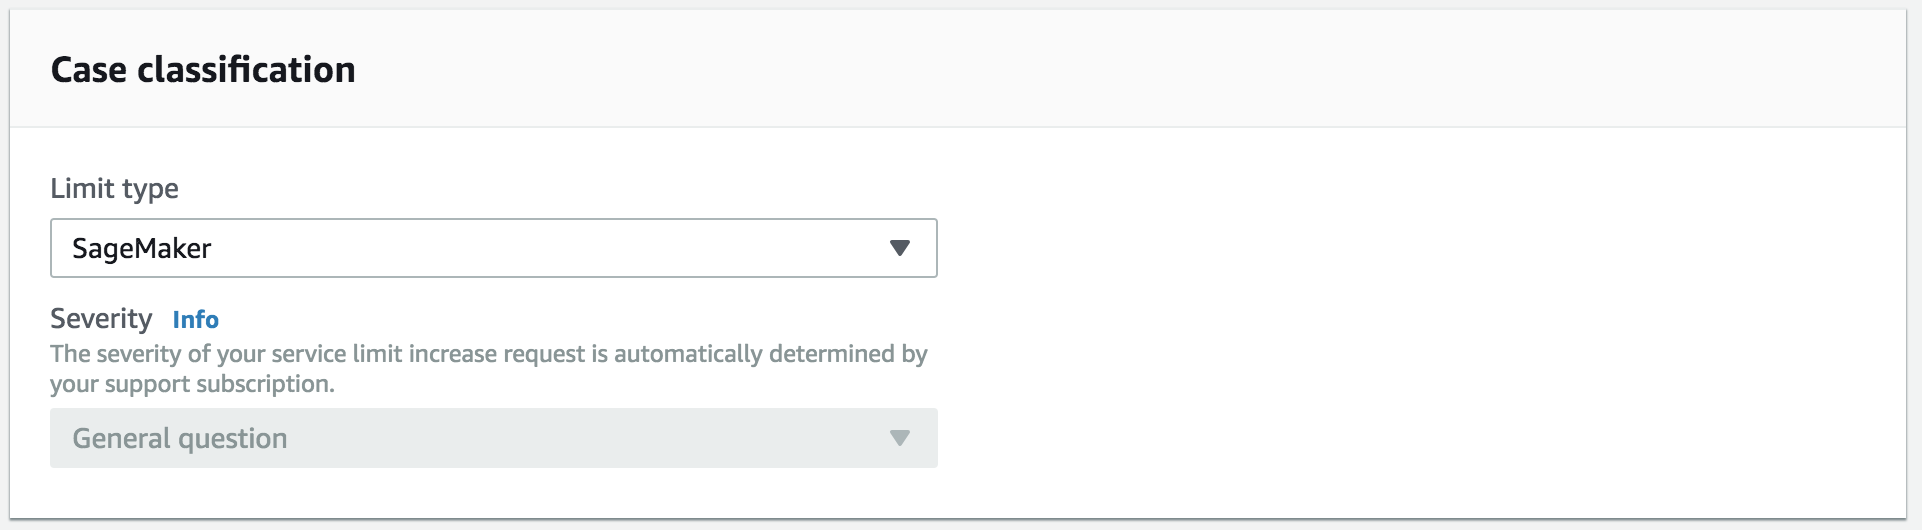

4.	Select the following under Requests (with your region of choice for this workshop): 

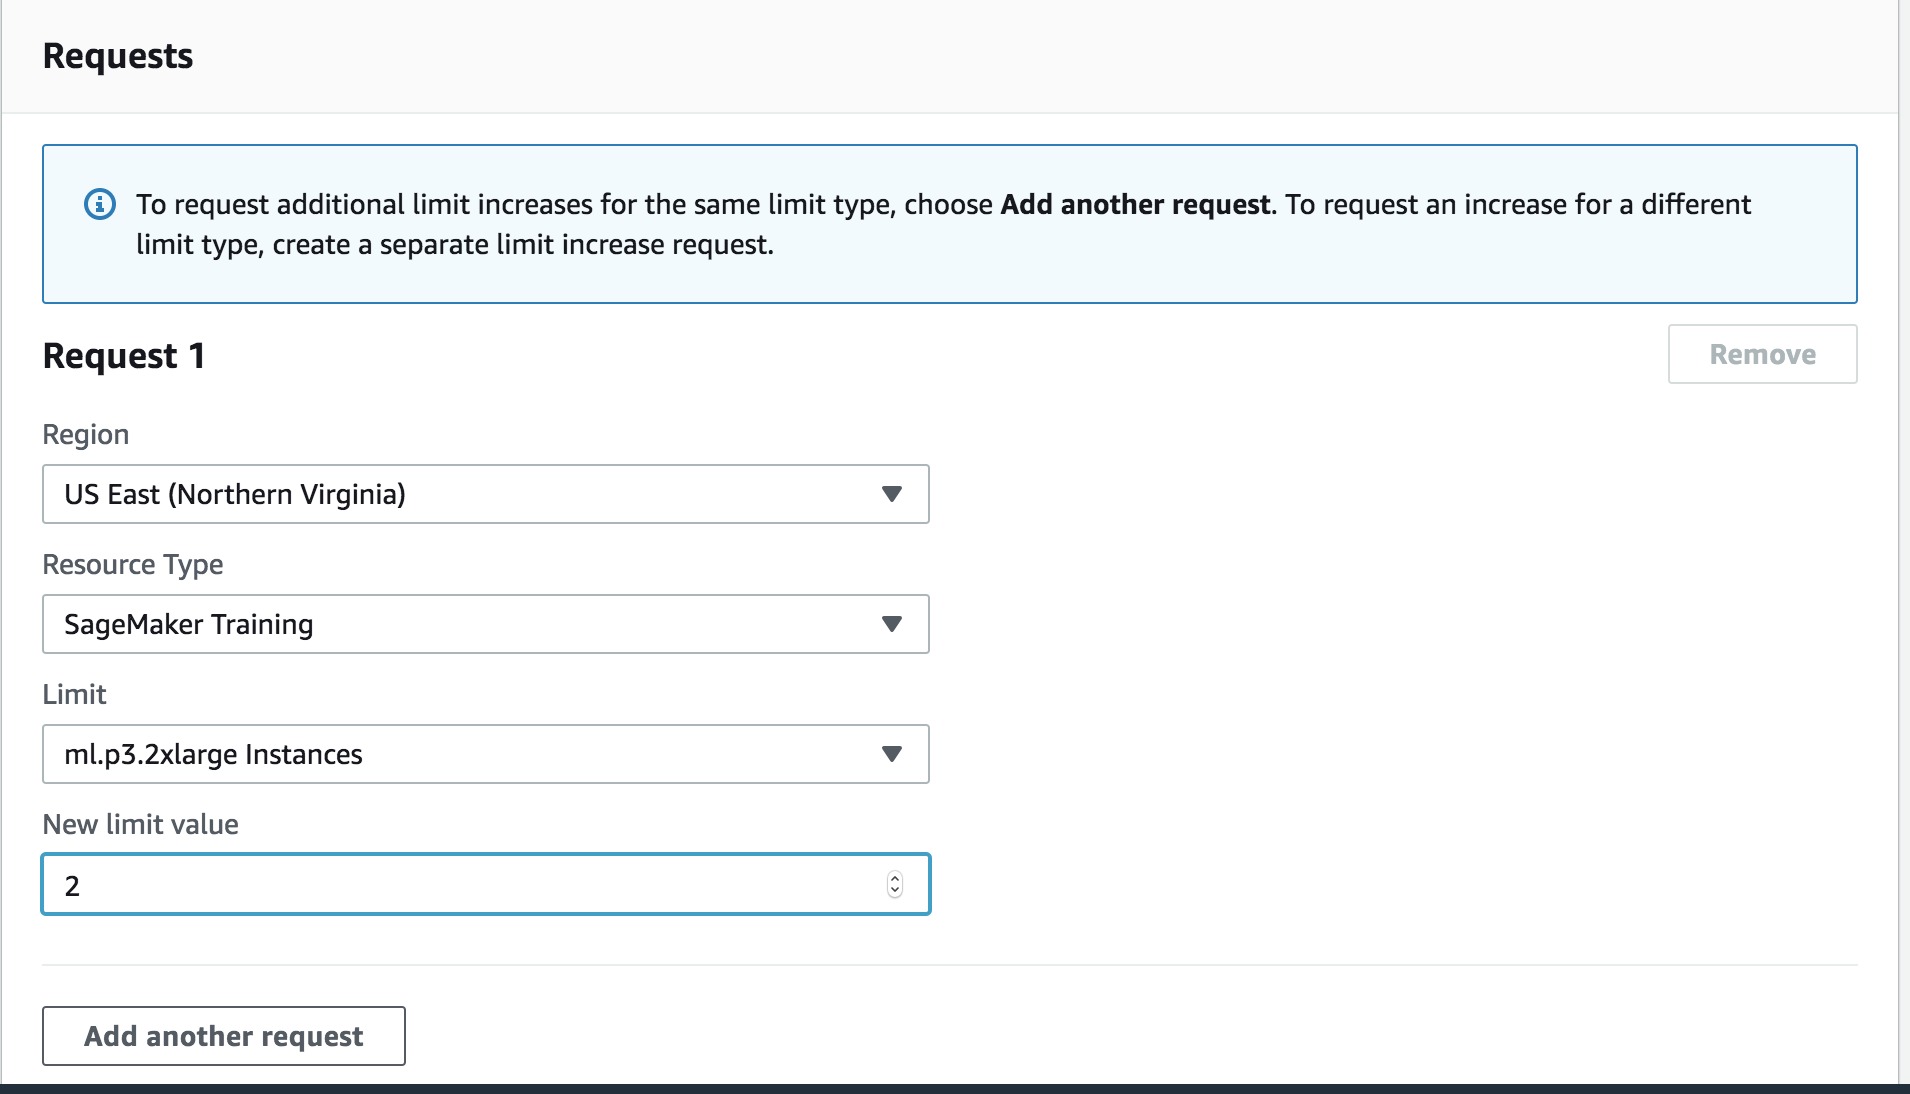

5.	Under Use Case Description type ‘Urgent request for Sydney Summit workshop’.
6.	Choose Submit.
7.	This can take up to 24 hours to come through. We will go through the full lab with 1,000 images on the screen and you can come back to try it out once the limit increase has come through.

**NOTE:** Object detection is a complex task, and training neural networks to high accuracy requires large datasets and careful hyperparameter tuning. The following cells illustrate how to train a neural network using a Ground Truth output augmented manifest, and how to interpret the results. However, we shouldn't expect a network trained on 10 or 1000 images to do a great job on unseen images!

First, we'll split our augmented manifest into a training set and a validation set using an 80/20 split and save the results to files that the model will use during training.

In [ ]:
with open('output.manifest', 'r') as f:
    output = [json.loads(line) for line in f.readlines()]

# Shuffle output in place.
np.random.shuffle(output)
    
dataset_size = len(output)
train_test_split_index = round(dataset_size*0.8)

train_data = output[:train_test_split_index]
validation_data = output[train_test_split_index:]

num_training_samples = 0
with open('train.manifest', 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')
        num_training_samples += 1
    
with open('validation.manifest', 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')

Next, we'll upload these manifest files to the previously defined S3 bucket so that they can be used in the training job.

In [ ]:
!aws s3 cp train.manifest s3://{BUCKET}/{EXP_NAME}/train.manifest
!aws s3 cp validation.manifest s3://{BUCKET}/{EXP_NAME}/validation.manifest

## Setup

Here we define S3 file paths for input and output data, the training image containing the object detection algorithm, and instantiate a SageMaker session.

In [ ]:
import re
from sagemaker import get_execution_role
from time import gmtime, strftime

role = get_execution_role()
sess = sagemaker.Session()
s3 = boto3.resource('s3')

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'object-detection', repo_version='latest')
augmented_manifest_filename_train = 'train.manifest'
augmented_manifest_filename_validation = 'validation.manifest'
bucket_name = BUCKET
s3_prefix = EXP_NAME
s3_output_path = 's3://{}/groundtruth-od-augmented-manifest-output'.format(bucket_name) # Replace with your desired output directory.

In [ ]:
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(bucket_name, s3_prefix, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(bucket_name, s3_prefix, augmented_manifest_filename_validation)

print("Augmented manifest for training data: {}".format(s3_train_data_path))
print("Augmented manifest for validation data: {}".format(s3_validation_data_path))

In [ ]:
augmented_manifest_s3_key = s3_train_data_path.split(bucket_name)[1][1:]
s3_obj = s3.Object(bucket_name, augmented_manifest_s3_key)
augmented_manifest = s3_obj.get()['Body'].read().decode('utf-8')
augmented_manifest_lines = augmented_manifest.split('\n')
num_training_samples = len(augmented_manifest_lines) # Compute number of training samples for use in training job request.

# Determine the keys in the training manifest and exclude the meta data from the labling job.
attribute_names = list(json.loads(augmented_manifest_lines[0]).keys())
attribute_names = [attrib for attrib in attribute_names if 'meta' not in attrib]

In [ ]:
try:
    if attribute_names == ["source-ref", "XXXX"]:
        raise Exception("The 'attribute_names' variable is set to default values. Please check your augmented manifest file for the label attribute name and set the 'attribute_names' variable accordingly.")
except NameError:
    raise Exception("The attribute_names variable is not defined. Please check your augmented manifest file for the label attribute name and set the 'attribute_names' variable accordingly.")

# Create unique job name
job_name_prefix = 'ground-truthod-demo'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_job_name = job_name_prefix + timestamp

training_params = \
    {
        "AlgorithmSpecification": {
            # NB. This is one of the named constants defined in the first cell.
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p3.2xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": model_job_name,
        "HyperParameters": {  # NB. These hyperparameters are at the user's discretion and are beyond the scope of this demo.
            "base_network": "resnet-50",
            "use_pretrained_model": "1",
            "num_classes": "1",
            "mini_batch_size": "1",
            "epochs": "30",
            "learning_rate": "0.001",
            "lr_scheduler_step": "",
            "lr_scheduler_factor": "0.1",
            "optimizer": "sgd",
            "momentum": "0.9",
            "weight_decay": "0.0005",
            "overlap_threshold": "0.5",
            "nms_threshold": "0.45",
            "image_shape": "300",
            "label_width": "350",
            "num_training_samples": str(num_training_samples)
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_train_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": attribute_names
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_validation_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": attribute_names
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            }
        ]
    }

print('Training job name: {}'.format(model_job_name))
print('\nInput Data Location: {}'.format(
    training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))


Now we create the SageMaker training job.

In [ ]:
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

# Confirm that the training job has started
status = client.describe_training_job(TrainingJobName=model_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

To check the progess of the training job, you can repeatedly evaluate the following cell. When the training job status reads `'Completed'`, move on to the next part of the tutorial.

In [ ]:
client = boto3.client(service_name='sagemaker')
print("Training job status: ", client.describe_training_job(TrainingJobName=model_job_name)['TrainingJobStatus'])
print("Secondary status: ", client.describe_training_job(TrainingJobName=model_job_name)['SecondaryStatus'])

In [ ]:
training_info = client.describe_training_job(TrainingJobName=model_job_name)

# Deploy the Model 

Now that we've fully labeled our dataset and have a trained model, we want to use the model to perform inference.

Object detection only supports encoded .jpg and .png image formats as inference input for now. The output is in JSON format, or in JSON Lines format for batch transform.

This section involves several steps:
1. Create Model: Create model for the training output
2. Batch Transform: Create a transform job to perform batch inference.
3. Host the model for realtime inference: Create an inference endpoint and perform realtime inference.

## Create Model

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name='groundtruth-demo-od-model' + timestamp
print(model_name)
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = sagemaker_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

## Batch Transform
We now create a SageMaker Batch Transform job using the model created above to perform batch prediction.

### Download Test Data
First, let's download a test image that has been held out from the training and validation data.

In [ ]:
# Find a bird not in the images labeled by Ground Truth.
img_ids = {img.filename.split('.')[0] for img in output_images}
with open('test-annotations-bbox.csv', 'r') as f:
    for line in f.readlines()[1:]:
        line = line.strip().split(',')
        img_id, _, cls_id, conf, xmin, xmax, ymin, ymax, *_ = line
        if img_id in skip_these_images:
            continue
        if cls_id in good_subclasses:
            # Skip the first several images
            if str(img_id) not in img_ids:
                test_bird = img_id
                break

In [ ]:
from IPython.display import Image

test_image =  test_bird + '.jpg'
os.system(f'wget https://s3.amazonaws.com/open-images-dataset/test/{test_image}')
Image(test_image)

In [ ]:
batch_input = 's3://{}/{}/test/'.format(BUCKET, EXP_NAME)
print(test_image)

!aws s3 cp $test_image $batch_input

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "object-detection-model" + timestamp
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/{}/output/'.format(BUCKET, EXP_NAME, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))

In [ ]:
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker_client.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)

### Inspect the results

The following cell plots the predicted bounding boxes for our example image. You'll notice that inside the function `get_predictions`, we filter the output to only include bounding boxes with a confidence score above a certain threshold (in this case, 0.2). This is because the object detection model we have trained always ouputs a fixed number of box candidates, and we must include a cutoff to eliminate the spurious results.

In [ ]:
s3_client = boto3.client('s3')

batch_output = 's3://{}/{}/{}/output/'.format(BUCKET, EXP_NAME, batch_job_name)


def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content['Key'] for content in response['Contents']]
    return objects


def get_predictions(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        predictions = data['prediction']

    # Return only the predictions with confidence above the threshold of 0.2.
    return [prediction for prediction in predictions if prediction[1] > 0.2]


def make_predicted_image(predictions, img_id, uri):
    '''Maked a BoxedImage object with output of batch/realtime prediction.

    Args:
      predictions: list, output of get_predictions.
      uri: str, s3 uri of input image.

    Returns:
      BoxedImage object with predicted bounding boxes.
    '''
    img = BoxedImage(id=img_id, uri=uri)
    img.download('.')
    imread_img = img.imread()
    imh, imw, *_ = imread_img.shape

    # Create boxes.
    for batch_data in batch_boxes_data:
        class_id, confidence, xmin, ymin, xmax, ymax = batch_data
        boxdata = {'class_id': class_id,
                   'height': (ymax-ymin)*imh,
                   'width': (xmax-xmin)*imw,
                   'left': xmin*imw,
                   'top': ymin*imh}
        box = BoundingBox(boxdata=boxdata, image_id=img.id)
        img.consolidated_boxes.append(box)

    return img


inputs = list_objects(s3_client, BUCKET, urlparse(
    batch_input).path.lstrip('/'))
print("Input: " + str(inputs[:2]))

outputs = list_objects(s3_client, BUCKET, urlparse(
    batch_output).path.lstrip('/'))
print("Output: " + str(outputs[:2]))

# Download prediction results.
batch_boxes_data = get_predictions(s3_client, BUCKET, outputs[0])
batch_uri = f's3://{BUCKET}/{inputs[0]}'
batch_img = make_predicted_image(batch_boxes_data, 'BatchTest', batch_uri)

# Plot the image and predicted boxes.
fig, ax = plt.subplots()
batch_img.plot_consolidated_bbs(ax)


## Realtime Inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps:

1. Create endpoint configuration - Create a configuration defining an endpoint.
2. Create endpoint - Use the configuration to create an inference endpoint.
3. Perform inference - Perform inference on some input data using the endpoint.
4. Clean up - Delete the endpoint and model

### Create Endpoint Configuration

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc' + timestamp
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

### Create Endpoint

The next cell creates an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker_client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

# wait until the status has changed
sagemaker_client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

### Perform inference

The following cell transforms the image into the appropriate format for realtime prediction, submits the job, receives the prediction from the endpoint, and plots the result.

In [ ]:
with open(test_image, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

client = boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

result = response['Body'].read()
result = json.loads(result)
predictions = [prediction for prediction in result['prediction'] if prediction[1] > .2]
realtime_uri = batch_uri
realtime_img = make_predicted_image(predictions, 'RealtimeTest', realtime_uri)

# Plot the realtime prediction.
fig, ax = plt.subplots()
realtime_img.download('.')
realtime_img.plot_consolidated_bbs(ax)

### Clean up

Finally, let's clean up and delete this endpoint.

In [ ]:
boto3.client(service_name='sagemaker').delete_endpoint(EndpointName=endpoint_name)

# Review

We covered a lot of ground in this notebook! Let's recap what we accomplished. First we started with an unlabeled dataset (technically, the dataset was previously labeled by the authors of the dataset, but we discarded the original labels for the purposes of this demonstration). Next, we created a SageMake Ground Truth labeling job and generated new labels for all of the images in our dataset. Then we split this file into a training set and a validation set and trained a SageMaker object detection model. Next, we trained a new model using these Ground Truth results and submitted a batch job to label a held-out image from the original dataset. Finally, we created a hosted model endpoint and used it to make a live prediction for the same held-out image.